# Nblineage E2E Test - Basic Functionality on JupyterLab

- Test that Nblineage extension works properly on JupyterLab
- Verify notebook and default cell MEME IDs are generated
- Add a new cell and verify it gets MEME ID
- Verify previous and next fields are correctly set
- Verify history is recorded when cell order changes
- Verify all previous/next fields are correct after cell move
- Verify branching when cell is copied

In [1]:
# Default parameters (will be overridden by Papermill)
jupyterlab_url = "http://localhost:8888/lab"
jupyter_token = "test-token"
default_result_path = None
close_on_fail = False
transition_timeout = 30000
jupyter_work_dir = '../artifacts/jupyter-work'

In [3]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
print(f"Created work directory: {work_dir}")

Created work directory: /var/folders/tb/rx5f2b6d0jn3g81h4wm1p6b80000gn/T/tmpq7056re9


In [4]:
import re
import importlib

import scripts.playwright
importlib.reload(scripts.playwright)

import scripts.jupyterlab
importlib.reload(scripts.jupyterlab)

from scripts.playwright import *
from scripts.jupyterlab import *

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20251226-153158',
 '/var/folders/tb/rx5f2b6d0jn3g81h4wm1p6b80000gn/T/tmpfkxwhw7x')

## Open JupyterLab and wait for it to load

Start epoch: 1766730718.726351 seconds


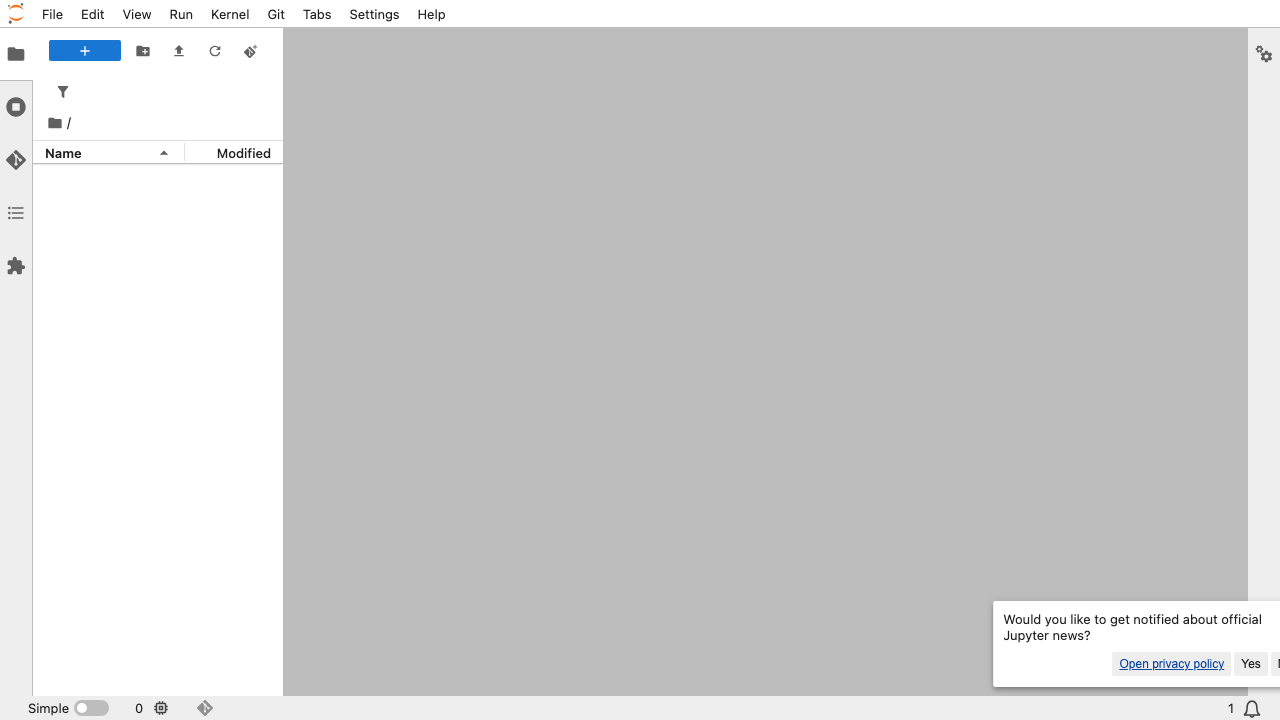

In [5]:
async def _step_wait_for_loading(page):
    await page.goto(f"{jupyterlab_url}?token={jupyter_token}")
    
    # Wait for JupyterLab to load
    await expect(page.locator('#jp-main-dock-panel')).to_be_visible(timeout=transition_timeout)

    # Wait for file browser to be visible
    await expect(page.locator('.jp-DirListing')).to_be_visible(timeout=transition_timeout)


await run_pw(_step_wait_for_loading)

## Remove existing test notebook if it exists

Start epoch: 1766730721.081412 seconds
No existing test notebook to remove


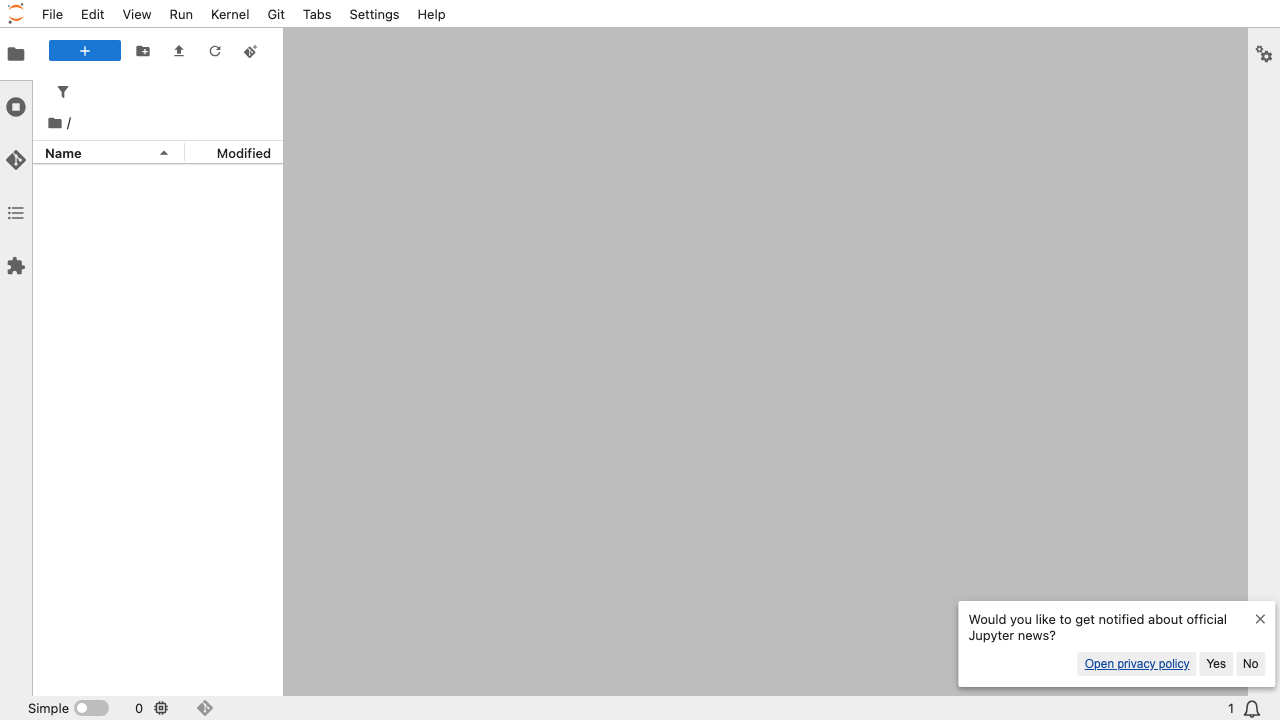

In [6]:
test_filename = "TestBasicLabNotebook.ipynb"
async def _step_remove_existing_notebook(page):
    deleted = await delete_file(page, test_filename, timeout=transition_timeout)
    if deleted:
        print("✓ Removed existing test notebook")
    else:
        print("No existing test notebook to remove")

await run_pw(_step_remove_existing_notebook)

## Create a new notebook for testing

Start epoch: 1766730721.236833 seconds


✓ New notebook created


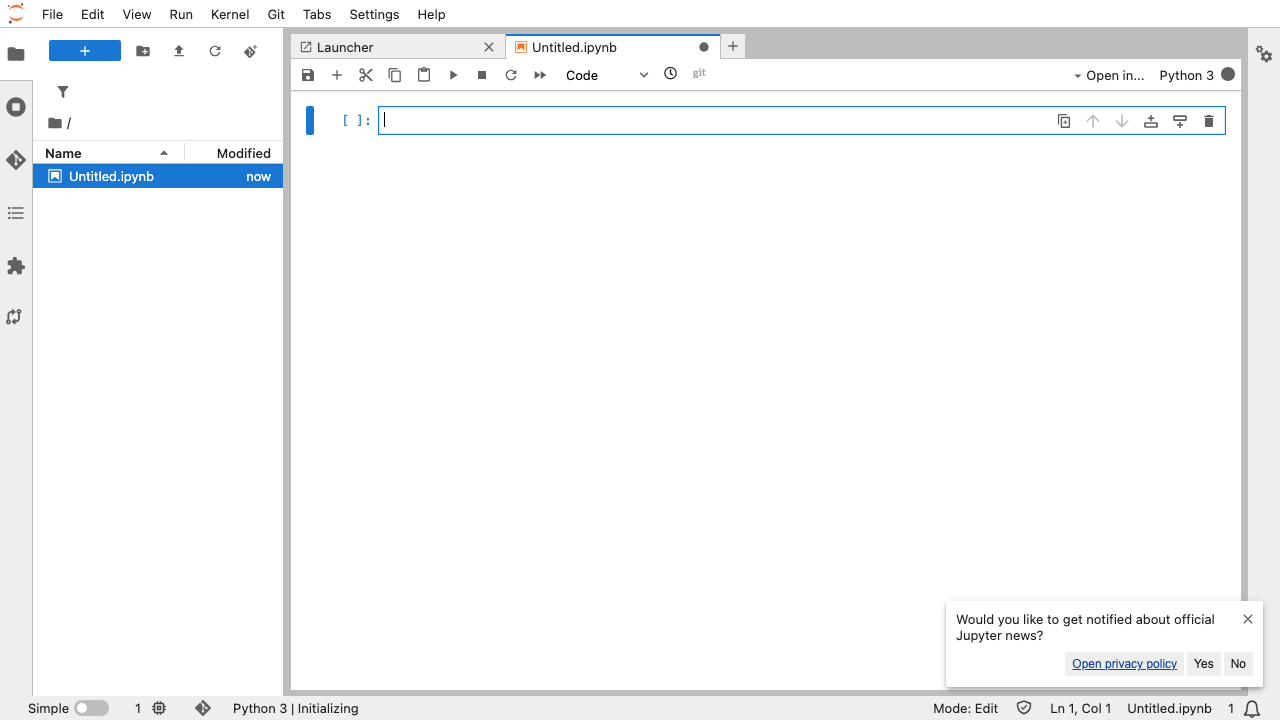

In [7]:
async def _step_create_notebook(page):
    # Create a new notebook using the jupyterlab helper
    # In JupyterLab, notebook opens in the same page
    await create_new_notebook(page, timeout=transition_timeout)
    print(f"✓ New notebook created")

await run_pw(_step_create_notebook)

## Rename and save the notebook

Start epoch: 1766730722.931387 seconds


✓ Notebook renamed and saved: TestBasicLabNotebook.ipynb


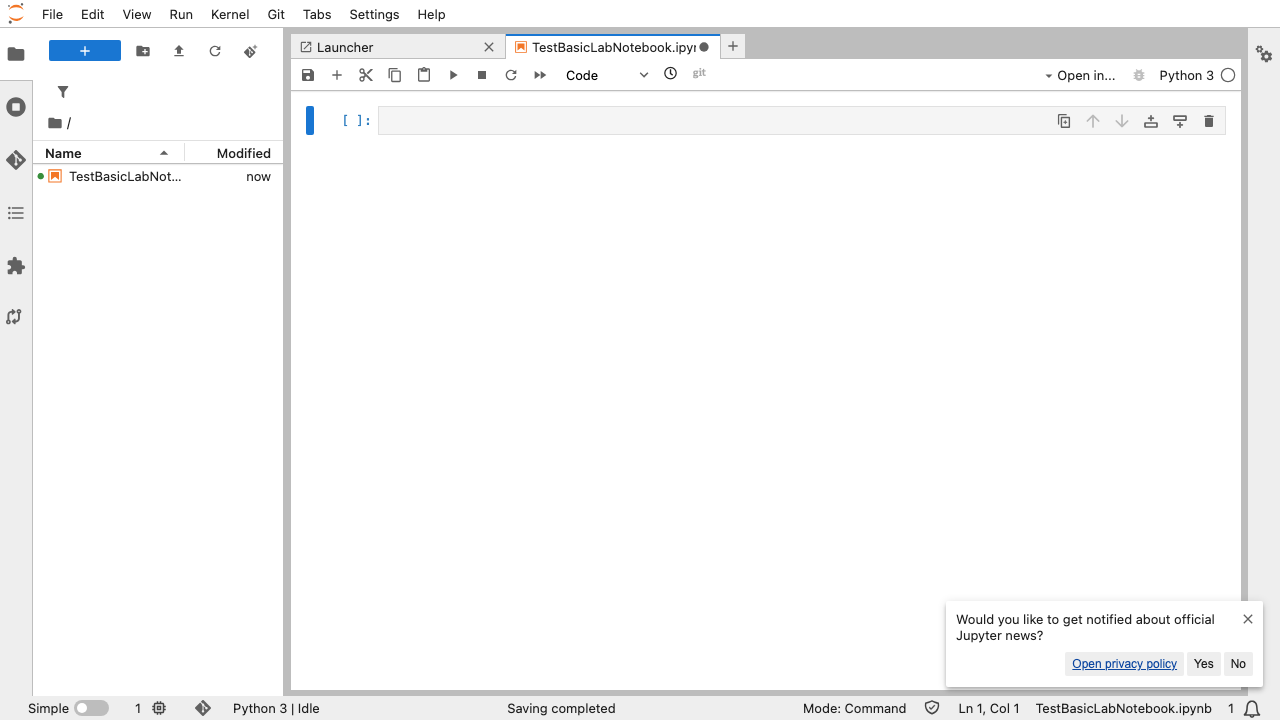

In [8]:
async def _step_rename_and_save(page):
    # Rename the notebook
    await rename_notebook(page, test_filename, timeout=transition_timeout)
    
    # Save the notebook
    await save_notebook(page)
    
    print(f"✓ Notebook renamed and saved: {test_filename}")

await run_pw(_step_rename_and_save)

## Execute a cell to trigger nblineage

Start epoch: 1766730724.730703 seconds


✓ Cell executed


✓ Notebook saved


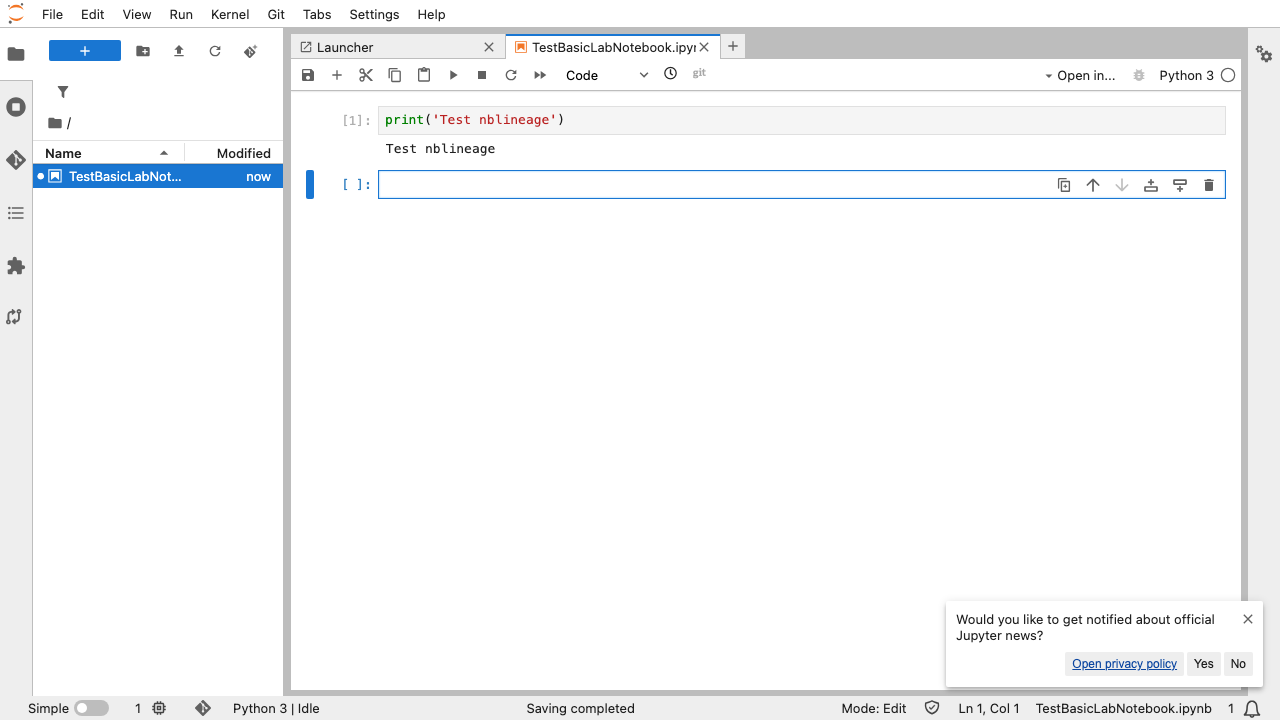

In [9]:
async def _step_execute_cell(page):
    # Create and execute a cell
    await set_cell(page, 0, "code", "print('Test nblineage')", timeout=transition_timeout)
    await run_cell(page, 0, True, timeout=transition_timeout)
    print("✓ Cell executed")
    
    # Save the notebook
    await save_notebook(page)
    print("✓ Notebook saved")

await run_pw(_step_execute_cell)

## Verify notebook and default cell MEME IDs are generated

Start epoch: 1766730729.039202 seconds
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb
✓ nblineage meme found in notebook metadata
✓ Notebook 'current' is a valid UUID: 970029be-e224-11f0-8854-0242ac110002
✓ nblineage cell meme found in first cell metadata
✓ First cell 'current' is a valid UUID: 97002a7c-e224-11f0-8854-0242ac110002


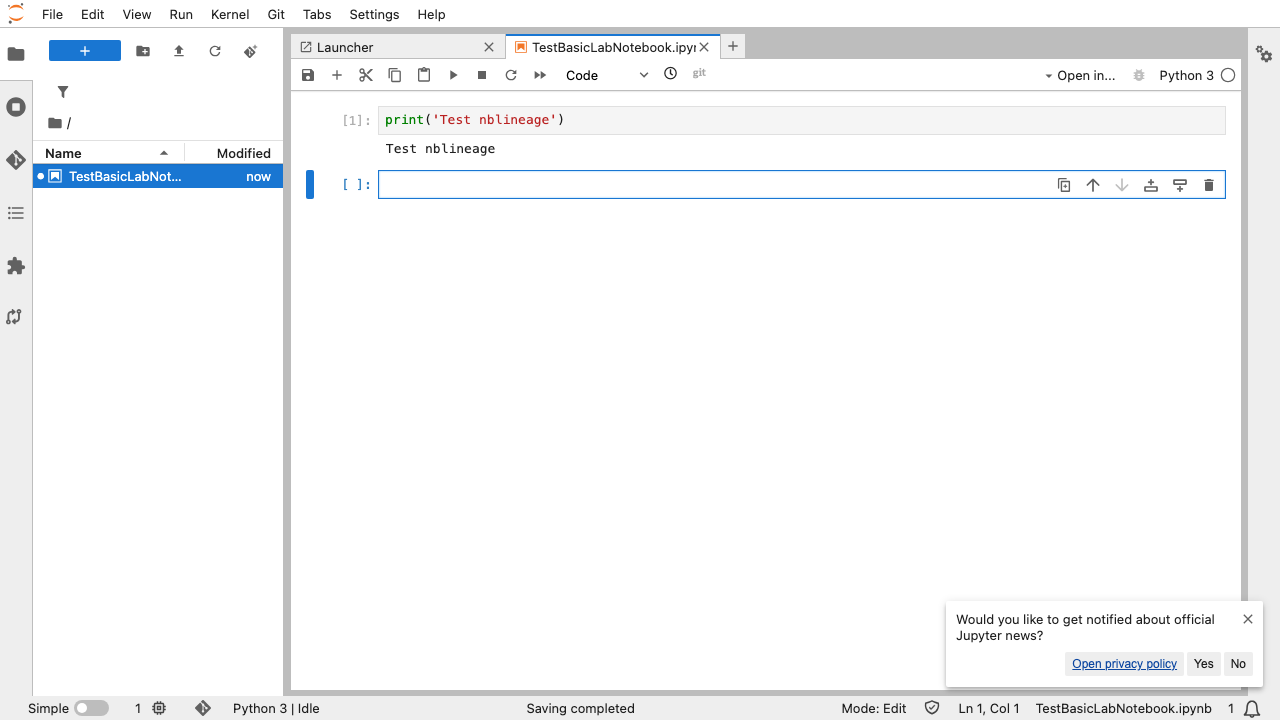

In [10]:
import json
from pathlib import Path

async def _test_notebook_and_cell_meme_id(page):
    # Read notebook file directly from jupyter_work_dir
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)
    
    print(f"✓ Loaded notebook from: {notebook_path}")
    
    # Check notebook MEME ID
    assert 'metadata' in notebook_data, "No metadata in notebook content"
    assert 'lc_notebook_meme' in notebook_data['metadata'], "No lc_notebook_meme in notebook metadata"
    
    print("✓ nblineage meme found in notebook metadata")

    meme = notebook_data['metadata']['lc_notebook_meme']
    assert 'current' in meme, "No 'current' in lc_notebook_meme"
    
    notebook_current = meme['current']
    uuid_pattern = r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$'
    assert re.match(uuid_pattern, notebook_current), f"Notebook 'current' is not a valid UUID: {notebook_current}"

    print(f"✓ Notebook 'current' is a valid UUID: {notebook_current}")

    # Check first cell MEME ID
    cells = notebook_data['cells']
    assert len(cells) > 0, "No cells in notebook"
    
    first_cell = cells[0]
    assert 'metadata' in first_cell, "No metadata in first cell"
    assert 'lc_cell_meme' in first_cell['metadata'], "No lc_cell_meme in first cell metadata"
    
    print("✓ nblineage cell meme found in first cell metadata")
    
    cell_meme = first_cell['metadata']['lc_cell_meme']
    assert 'current' in cell_meme, "No 'current' in lc_cell_meme"
    
    cell_current = cell_meme['current']
    assert re.match(uuid_pattern, cell_current), f"Cell 'current' is not a valid UUID: {cell_current}"
    
    print(f"✓ First cell 'current' is a valid UUID: {cell_current}")

await run_pw(_test_notebook_and_cell_meme_id)

## Add a new cell and verify it gets MEME ID

Start epoch: 1766730729.1381419 seconds


✓ New cell added


✓ Notebook saved after adding new cell
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb
✓ nblineage cell meme found in second cell metadata
✓ Second cell 'current' is a valid UUID: 9a04c17e-e224-11f0-8854-0242ac110002
✓ All MEME ID auto-generation tests passed!


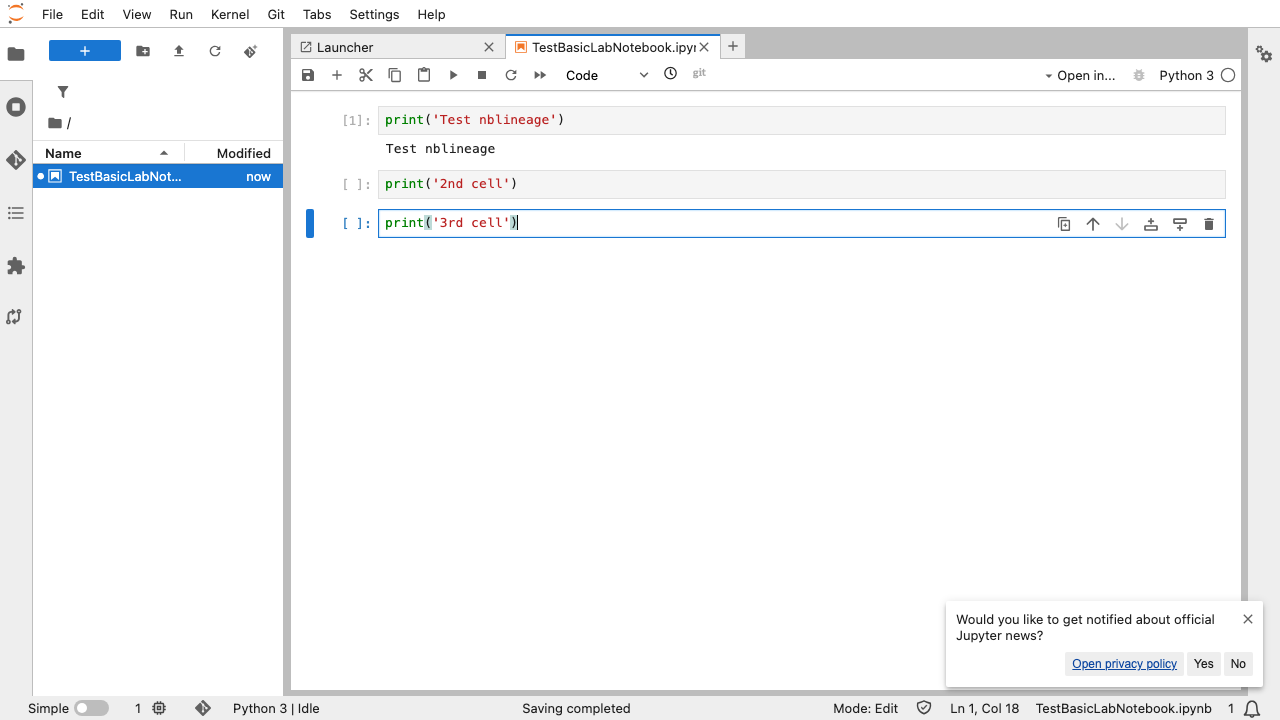

In [11]:
async def _test_new_cell_meme_id(page):
    # Add a new cell using the add_cell helper
    await set_cell(page, 1, "code", "print('2nd cell')", timeout=transition_timeout)
    await add_cell(page, "code", "print('3rd cell')", timeout=transition_timeout)
    print("✓ New cell added")
    
    # Save the notebook to persist the new cell
    await save_notebook(page)
    print("✓ Notebook saved after adding new cell")
    
    # Read the updated notebook
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)
    
    print(f"✓ Loaded notebook from: {notebook_path}")
    
    # Check second cell meme
    cells = notebook_data['cells']
    assert len(cells) >= 2, f"Expected at least 2 cells, found {len(cells)}"
    
    second_cell = cells[1]
    assert 'metadata' in second_cell, "No metadata in second cell"
    assert 'lc_cell_meme' in second_cell['metadata'], "No lc_cell_meme in second cell metadata"
    
    print("✓ nblineage cell meme found in second cell metadata")
    
    cell_meme = second_cell['metadata']['lc_cell_meme']
    assert 'current' in cell_meme, "No 'current' in lc_cell_meme"
    
    cell_current = cell_meme['current']
    uuid_pattern = r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$'
    assert re.match(uuid_pattern, cell_current), f"Second cell 'current' is not a valid UUID: {cell_current}"
    
    print(f"✓ Second cell 'current' is a valid UUID: {cell_current}")
    print("✓ All MEME ID auto-generation tests passed!")

await run_pw(_test_new_cell_meme_id)

## Verify previous and next fields are correctly set

Start epoch: 1766730735.304287 seconds
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb
Testing previous/next fields for 3 cells

Cell 0:
  current: 97002a7c-e224-11f0-8854-0242ac110002
  previous: None
  next: 9a04c17e-e224-11f0-8854-0242ac110002
  ✓ First cell has previous=None
  ✓ next matches next cell's current

Cell 1:
  current: 9a04c17e-e224-11f0-8854-0242ac110002
  previous: 97002a7c-e224-11f0-8854-0242ac110002
  next: 9c489cbc-e224-11f0-8854-0242ac110002
  ✓ previous matches previous cell's current
  ✓ next matches next cell's current

Cell 2:
  current: 9c489cbc-e224-11f0-8854-0242ac110002
  previous: 9a04c17e-e224-11f0-8854-0242ac110002
  next: None
  ✓ previous matches previous cell's current
  ✓ Last cell has next=None

✓ All previous/next fields are correctly set!


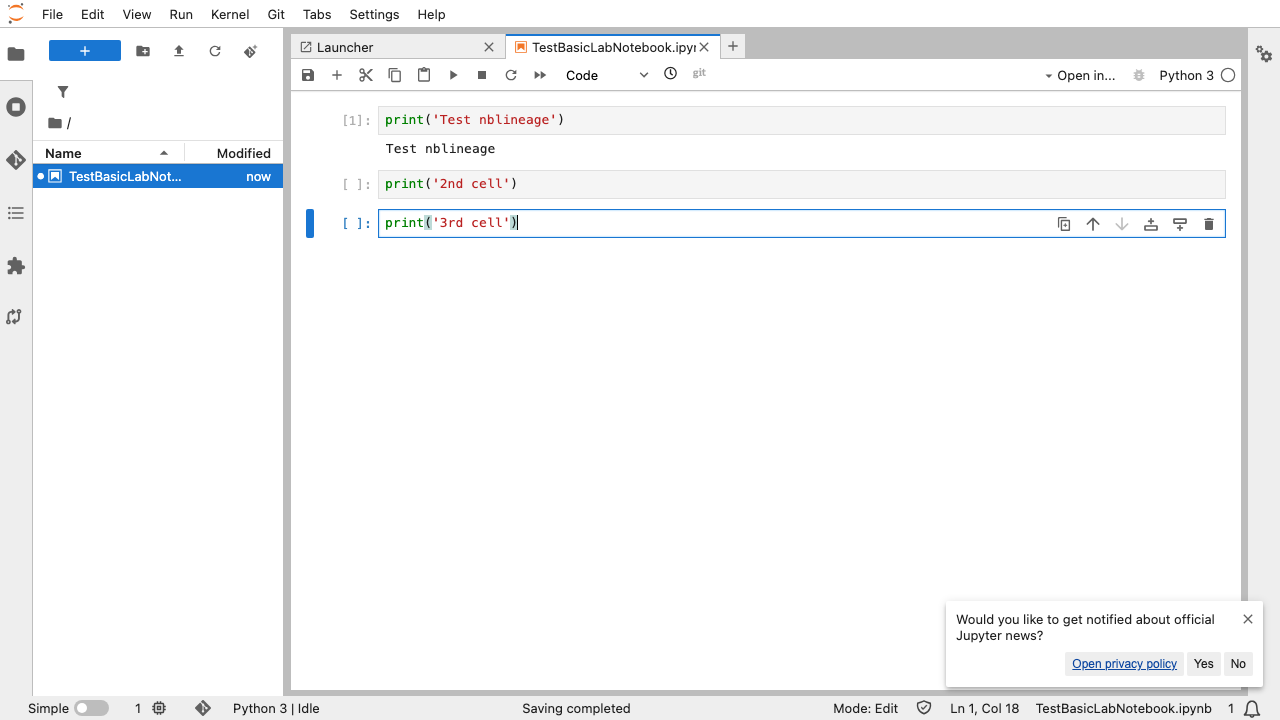

In [12]:
async def _test_previous_next_fields(page):
    # Read notebook file
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)
    
    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells = notebook_data['cells']
    assert len(cells) >= 2, f"Expected at least 2 cells for previous/next test, found {len(cells)}"
    
    print(f"Testing previous/next fields for {len(cells)} cells")
    
    for i, cell in enumerate(cells):
        cell_meme = cell['metadata']['lc_cell_meme']
        current = cell_meme['current']
        previous = cell_meme.get('previous')
        next_meme = cell_meme.get('next')
        
        print(f"\nCell {i}:")
        print(f"  current: {current}")
        print(f"  previous: {previous}")
        print(f"  next: {next_meme}")
        
        # Check first cell
        if i == 0:
            assert previous is None, f"First cell (index {i}) should have previous=None, but got: {previous}"
            print(f"  ✓ First cell has previous=None")
        else:
            # Check that previous points to the previous cell's current
            prev_cell_meme = cells[i-1]['metadata']['lc_cell_meme']
            expected_previous = prev_cell_meme['current']
            assert previous == expected_previous, f"Cell {i} previous={previous}, expected={expected_previous}"
            print(f"  ✓ previous matches previous cell's current")
        
        # Check last cell
        if i == len(cells) - 1:
            assert next_meme is None, f"Last cell (index {i}) should have next=None, but got: {next_meme}"
            print(f"  ✓ Last cell has next=None")
        else:
            # Check that next points to the next cell's current
            next_cell_meme = cells[i+1]['metadata']['lc_cell_meme']
            expected_next = next_cell_meme['current']
            assert next_meme == expected_next, f"Cell {i} next={next_meme}, expected={expected_next}"
            print(f"  ✓ next matches next cell's current")
    
    print("\n✓ All previous/next fields are correctly set!")

await run_pw(_test_previous_next_fields)

## Verify history is recorded when cell order changes

Start epoch: 1766730735.518615 seconds
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb

Before move - Cell 1 (second cell):
  current: 9a04c17e-e224-11f0-8854-0242ac110002
  previous: 97002a7c-e224-11f0-8854-0242ac110002
  next: 9c489cbc-e224-11f0-8854-0242ac110002
  history: []


✓ Cell moved up


✓ Notebook saved after cell move
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb

After move - Cell 0 (moved cell):
  current: 9a04c17e-e224-11f0-8854-0242ac110002-1-3398
  previous: None
  next: 97002a7c-e224-11f0-8854-0242ac110002
  history: [{'current': '9a04c17e-e224-11f0-8854-0242ac110002', 'next': '9c489cbc-e224-11f0-8854-0242ac110002', 'previous': '97002a7c-e224-11f0-8854-0242ac110002'}]
✓ history recorded: 1 entries
✓ history entry matches old state

✓ History test passed!


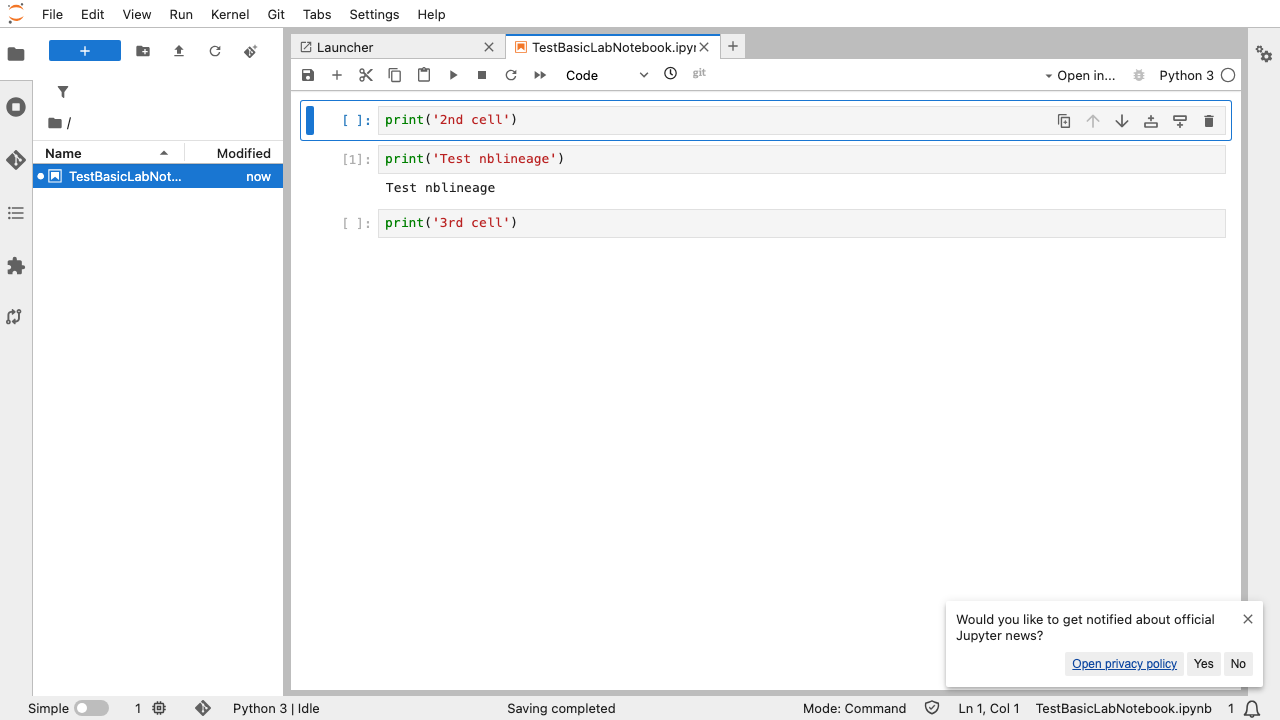

In [13]:
async def _test_history_on_cell_move(page):
    # First, get the current state before moving
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        before_data = json.load(f)
    
    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells_before = before_data['cells']
    assert len(cells_before) >= 2, f"Need at least 2 cells for move test, found {len(cells_before)}"
    
    # Record the state of the second cell (index 1) before moving
    second_cell_before = cells_before[1]['metadata']['lc_cell_meme']
    print(f"\nBefore move - Cell 1 (second cell):")
    print(f"  current: {second_cell_before['current']}")
    print(f"  previous: {second_cell_before.get('previous')}")
    print(f"  next: {second_cell_before.get('next')}")
    print(f"  history: {second_cell_before.get('history', [])}")
    
    # Move the second cell (index 1) up using the helper function
    await move_cell_up(page, 1, timeout=transition_timeout)
    print("✓ Cell moved up")
    
    # Save the notebook
    await save_notebook(page)
    print("✓ Notebook saved after cell move")
    
    # Read the updated notebook
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        after_data = json.load(f)
    
    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells_after = after_data['cells']
    
    # The moved cell should now be at index 0
    moved_cell = cells_after[0]['metadata']['lc_cell_meme']
    print(f"\nAfter move - Cell 0 (moved cell):")
    print(f"  current: {moved_cell['current']}")
    print(f"  previous: {moved_cell.get('previous')}")
    print(f"  next: {moved_cell.get('next')}")
    print(f"  history: {moved_cell.get('history', [])}")
    
    # Verify history was recorded
    history = moved_cell.get('history', [])
    assert len(history) > 0, "history should not be empty after cell move"
    print(f"✓ history recorded: {len(history)} entries")
    
    # Check the last history entry matches the old state
    last_history = history[-1]
    assert last_history['current'] == second_cell_before['current'], "history current should match old current"
    assert last_history.get('previous') == second_cell_before.get('previous'), "history previous should match old previous"
    assert last_history.get('next') == second_cell_before.get('next'), "history next should match old next"
    print("✓ history entry matches old state")
    
    print("\n✓ History test passed!")

await run_pw(_test_history_on_cell_move)

## Verify all previous/next fields are correct after cell move

Start epoch: 1766730737.442688 seconds
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb
Verifying all 3 cells have correct previous/next after move:

Cell 0:
  current: 9a04c17e-e224-11f0-8854-0242ac110002-1-3398
  previous: None
  next: 97002a7c-e224-11f0-8854-0242ac110002
  ✓ First cell has previous=None
  ✓ next matches next cell's current

Cell 1:
  current: 97002a7c-e224-11f0-8854-0242ac110002
  previous: 9a04c17e-e224-11f0-8854-0242ac110002-1-3398
  next: 9c489cbc-e224-11f0-8854-0242ac110002
  ✓ previous matches previous cell's current
  ✓ next matches next cell's current

Cell 2:
  current: 9c489cbc-e224-11f0-8854-0242ac110002
  previous: 97002a7c-e224-11f0-8854-0242ac110002
  next: None
  ✓ previous matches previous cell's current
  ✓ Last cell has next=None

✓ All previous/next fields are correct after move!


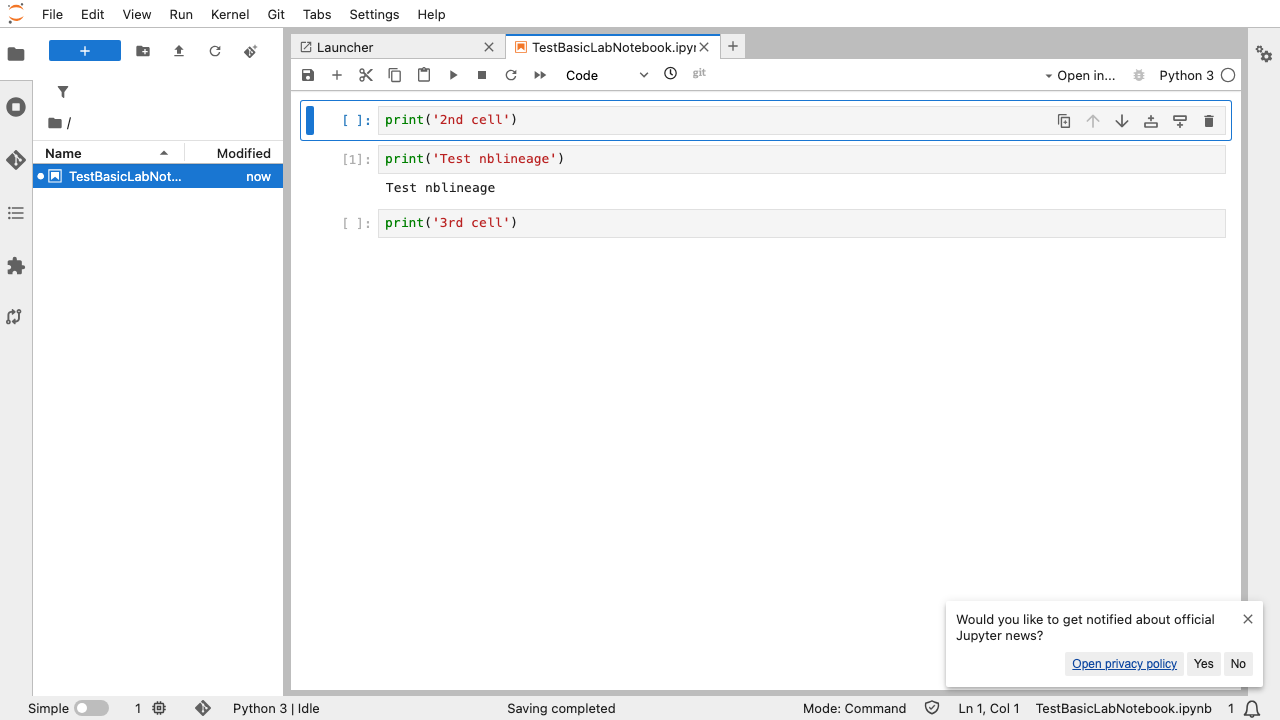

In [14]:
async def _test_previous_next_after_move(page):
    # Read notebook file
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        notebook_data = json.load(f)

    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells = notebook_data['cells']
    print(f"Verifying all {len(cells)} cells have correct previous/next after move:")
    
    for i, cell in enumerate(cells):
        cell_meme = cell['metadata']['lc_cell_meme']
        current = cell_meme['current']
        previous = cell_meme.get('previous')
        next_meme = cell_meme.get('next')
        
        print(f"\nCell {i}:")
        print(f"  current: {current}")
        print(f"  previous: {previous}")
        print(f"  next: {next_meme}")
        
        # Check first cell
        if i == 0:
            assert previous is None, f"First cell (index {i}) should have previous=None, but got: {previous}"
            print(f"  ✓ First cell has previous=None")
        else:
            # Check that previous points to the previous cell's current
            prev_cell_meme = cells[i-1]['metadata']['lc_cell_meme']
            expected_previous = prev_cell_meme['current']
            assert previous == expected_previous, f"Cell {i} previous={previous}, expected={expected_previous}"
            print(f"  ✓ previous matches previous cell's current")
        
        # Check last cell
        if i == len(cells) - 1:
            assert next_meme is None, f"Last cell (index {i}) should have next=None, but got: {next_meme}"
            print(f"  ✓ Last cell has next=None")
        else:
            # Check that next points to the next cell's current
            next_cell_meme = cells[i+1]['metadata']['lc_cell_meme']
            expected_next = next_cell_meme['current']
            assert next_meme == expected_next, f"Cell {i} next={next_meme}, expected={expected_next}"
            print(f"  ✓ next matches next cell's current")
    
    print("\n✓ All previous/next fields are correct after move!")

await run_pw(_test_previous_next_after_move)

## Verify branching when cell is copied

Start epoch: 1766730737.553683 seconds
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb

Before copy - Cell 1 (original cell):
  current: 97002a7c-e224-11f0-8854-0242ac110002


✓ Cell 1 copied (1st time)


✓ Cell pasted (1st time)


✓ Notebook saved after 1st copy
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb

After 1st copy - Cell 2 (first copied cell):
  current: 97002a7c-e224-11f0-8854-0242ac110002-1-f567
  Original parts: 5, First copy parts: 7
✓ First copied cell has more parts (branching)
  First copy branch_count: 1



✓ Cell 2 copied (2nd time)


✓ Cell pasted (2nd time)


✓ Notebook saved after 2nd copy
✓ Loaded notebook from: ../artifacts/jupyter-work/TestBasicLabNotebook.ipynb

After 2nd copy - Cell 3 (second copied cell):
  current: 97002a7c-e224-11f0-8854-0242ac110002-2-f567-2288
  Second copy parts: 8
✓ Second copied cell has more parts than first copy (branching continues)
  Second copy branch_count: 2
✓ branch_count increased from 1 to 2
✓ Base UUID matches original for both copies
✓ Base UUID is valid format

✓ Branching test passed!


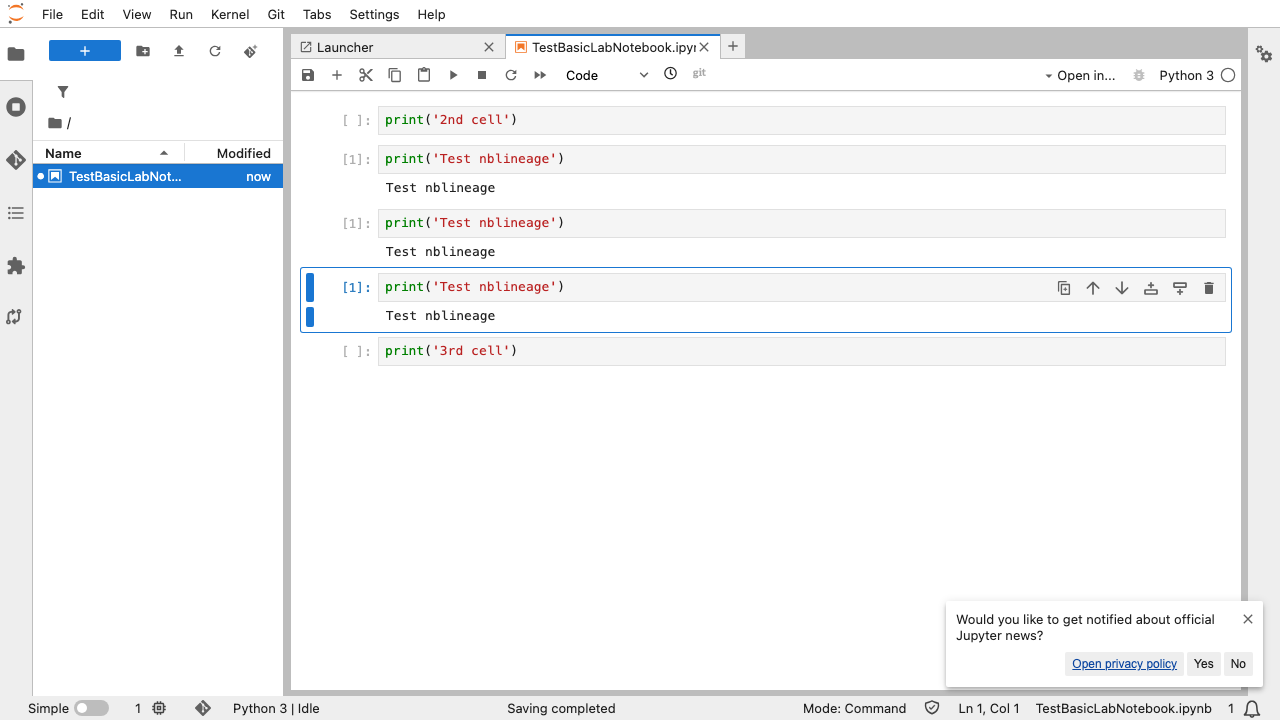

In [15]:
async def _test_branching_on_cell_copy(page):
    # Get the current state before copying
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        before_data = json.load(f)

    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells_before = before_data['cells']
    assert len(cells_before) >= 2, f"Need at least 2 cells for copy test, found {len(cells_before)}"
    
    # Get the second cell's (index 1) MEME ID before copying
    second_cell_before = cells_before[1]['metadata']['lc_cell_meme']
    original_current = second_cell_before['current']
    print(f"\nBefore copy - Cell 1 (original cell):")
    print(f"  current: {original_current}")
    
    # First copy: Copy Cell 1 and paste below
    await copy_cell(page, 1, timeout=transition_timeout)
    print("✓ Cell 1 copied (1st time)")
    
    await paste_cell_below(page, timeout=transition_timeout)
    print("✓ Cell pasted (1st time)")
    
    await page.wait_for_timeout(1000)
    
    # Save the notebook
    await save_notebook(page)
    print("✓ Notebook saved after 1st copy")
    
    # Read the updated notebook
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        after_first_copy = json.load(f)

    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells_after_first = after_first_copy['cells']
    # After first copy: Cell 0, Cell 1 (original), Cell 2 (1st copy)
    
    # The first copied cell is at index 2
    first_copied_cell = cells_after_first[2]['metadata']['lc_cell_meme']
    first_copied_current = first_copied_cell['current']
    
    print(f"\nAfter 1st copy - Cell 2 (first copied cell):")
    print(f"  current: {first_copied_current}")
    
    # Verify the copied cell has a branched MEME ID
    first_copied_parts = first_copied_current.split('-')
    original_parts = original_current.split('-')
    
    print(f"  Original parts: {len(original_parts)}, First copy parts: {len(first_copied_parts)}")
    
    assert len(first_copied_parts) > len(original_parts), f"First copied cell should have more parts than original: original={len(original_parts)}, copied={len(first_copied_parts)}"
    print("✓ First copied cell has more parts (branching)")
    
    # Extract branch_count from first copy (6th part, index 5)
    first_branch_count = int(first_copied_parts[5])
    print(f"  First copy branch_count: {first_branch_count}")
    
    # Second copy: Copy Cell 2 (the first copied cell) and paste below
    await copy_cell(page, 2, timeout=transition_timeout)
    print("\n✓ Cell 2 copied (2nd time)")
    
    await paste_cell_below(page, timeout=transition_timeout)
    print("✓ Cell pasted (2nd time)")
    
    await page.wait_for_timeout(1000)
    
    # Save the notebook
    await save_notebook(page)
    print("✓ Notebook saved after 2nd copy")
    
    # Read the updated notebook
    notebook_path = Path(jupyter_work_dir) / test_filename
    assert notebook_path.exists(), f"Notebook file not found: {notebook_path}"

    with open(notebook_path, 'r') as f:
        after_second_copy = json.load(f)

    print(f"✓ Loaded notebook from: {notebook_path}")
    
    cells_after_second = after_second_copy['cells']
    # After second copy: Cell 0, Cell 1 (original), Cell 2 (1st copy), Cell 3 (2nd copy)
    
    # The second copied cell is at index 3
    second_copied_cell = cells_after_second[3]['metadata']['lc_cell_meme']
    second_copied_current = second_copied_cell['current']
    
    print(f"\nAfter 2nd copy - Cell 3 (second copied cell):")
    print(f"  current: {second_copied_current}")
    
    # Verify the second copied cell also has branching
    second_copied_parts = second_copied_current.split('-')
    print(f"  Second copy parts: {len(second_copied_parts)}")
    
    assert len(second_copied_parts) > len(first_copied_parts), f"Second copied cell should have more parts than first copy: first={len(first_copied_parts)}, second={len(second_copied_parts)}"
    print("✓ Second copied cell has more parts than first copy (branching continues)")
    
    # Extract branch_count from second copy (6th part, index 5)
    second_branch_count = int(second_copied_parts[5])
    print(f"  Second copy branch_count: {second_branch_count}")
    
    # Verify branch_count has increased
    assert second_branch_count > first_branch_count, f"branch_count should increase: first={first_branch_count}, second={second_branch_count}"
    print(f"✓ branch_count increased from {first_branch_count} to {second_branch_count}")
    
    # Verify the base UUID (first 5 parts) matches the original for both copies
    original_base = '-'.join(original_parts[:5])
    first_copied_base = '-'.join(first_copied_parts[:5])
    second_copied_base = '-'.join(second_copied_parts[:5])
    
    assert original_base == first_copied_base, f"First copy base UUID should match: original={original_base}, copied={first_copied_base}"
    assert original_base == second_copied_base, f"Second copy base UUID should match: original={original_base}, copied={second_copied_base}"
    print("✓ Base UUID matches original for both copies")
    
    # Verify UUID format of base
    uuid_pattern = r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$'
    assert re.match(uuid_pattern, original_base), f"Base UUID should be valid: {original_base}"
    print("✓ Base UUID is valid format")
    
    print("\n✓ Branching test passed!")

await run_pw(_test_branching_on_cell_copy)

## Clean up

In [ ]:
await finish_pw_context()

In [17]:
!rm -fr {work_dir}